# TPP Attachment Limit investigation - Oct 2020

Hypothesis:
- TPP have increased the attachment limit and this has reduced the number of errors related to large attachments.

Context:
- TPP had a 60mb GP2GP attachment limit that should have been increased to 100mb over the last few months. We wanted to see if that change has reduced the number of errors related to large messages. 
- We are unable to access the MI Data, but we are able to access the SPINE logs. Therefore the following is based on data analysis from the SPINE logs.

Assumptions:
- TPP practices appear under the `YGA` ODS code

Requirements:
- This notebook uses the following Splunk query:
```
index="spine2vfmmonitor" service="gp2gp"
| search interactionID="urn:nhs:names:services:gp2gp/*"
| rex field=fromPartyID "(?<fromODSCode>.+?)(-\d+)"
| rex field=toPartyID "(?<toODSCode>.+?)(-\d+)"
| eval has_large_message_error = if(jdiEvent IN (23, 25, 29, 30, 31), 1, 0)
| eval is_tpp = if(fromODSCode="YGA" or toODSCode="YGA", 1, 0)
| stats
  earliest(_time) as timestamp
  max(has_large_message_error) as convo_has_large_message_error
  earliest(is_tpp) as is_tpp
  by conversationID
| eval month =  strftime(timestamp, "%m-%Y")
| eval convo_has_tpp_large_message_error = if(convo_has_large_message_error=1 and is_tpp=1, 1, 0)
| stats
  count as all_transfers
  sum(convo_has_large_message_error) as all_large_message_errors
  sum(is_tpp) as tpp_transfers
  sum(convo_has_tpp_large_message_error) as tpp_large_message_errors
by month
```

In [15]:
import paths
import pandas as pd
import data
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [16]:
%matplotlib inline

In [17]:
large_message_failures_df = pd.read_csv(
    data.PRMT_1192_large_message_errors.path
)

In [18]:
large_message_failures_df['tpp_lm_errors_perc']= large_message_failures_df['tpp_large_message_errors']/large_message_failures_df['tpp_transfers']

large_message_failures_df

,month,all_transfers,all_large_message_errors,tpp_transfers,tpp_large_message_errors,tpp_lm_errors_perc
0,Feb,220001,1584,77991,1319,0.016912
1,Mar,182906,1426,64055,1263,0.019717
2,Apr,92858,954,32824,882,0.026871
3,May,88008,949,32354,869,0.026859
4,Jun,128516,1374,48907,1257,0.025702
5,Jul,165670,1652,63031,1542,0.024464
6,Aug,165862,1554,64061,1435,0.022401
7,Sept,273966,2514,106008,2072,0.019546


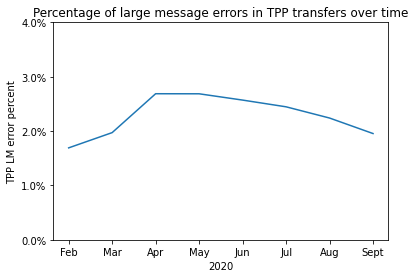

In [19]:
plt.title("Percentage of large message errors in TPP transfers over time")
plt.xlabel("2020")
plt.ylabel("TPP LM error percent")
plt.plot(large_message_failures_df["month"], large_message_failures_df["tpp_lm_errors_perc"])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 1))
plt.yticks(np.arange(0, 0.05, step=0.01))
plt.show()

## Conclusion

Based on the above graph it does not appear that there was a significant drop in TPP large message failures. Before we can confidently asses if the large attachment change has had an effect we would need either the MI data or spine logs enriched with attachment metadata. These results are based on several assumptions and more analysis should be done once the spine logs are enriched with supplier names or the MI data becomes available.